# Проект Дашборд конверсий

## ШАГ 1 Подготовка к работе с данными

In [140]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sea
import matplotlib.colors as matcol

## ШАГ 2 Запросы к API

### Запрос на данные по посещениям от даты 2023-03-01 до даты 2023-09-01:

In [26]:
visit_json=requests.get("https://data-charts-api.hexlet.app/visits?begin=2022-03-01&end=2023-09-01") #запрос по API по URL
data_vis=visit_json.json() #перевод в JSON
df_visits=pd.DataFrame(data_vis) #перевод JSON в DataFrame
df_visits.head()

,datetime,platform,user_agent,visit_id
0,"Wed, 01 Mar 2023 23:17:37 GMT",web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,1de9ea66-70d3-4a1f-8735-df5ef7697fb9
1,"Sat, 04 Mar 2023 03:23:34 GMT",web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,1de9ea66-70d3-4a1f-8735-df5ef7697fb9
2,"Wed, 01 Mar 2023 12:57:13 GMT",web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,f149f542-e935-4870-9734-6b4501eaf614
3,"Wed, 01 Mar 2023 13:07:19 GMT",web,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,08f0ebd4-950c-4dd9-8e97-b5bdf073eed1
4,"Sun, 05 Mar 2023 22:02:39 GMT",web,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,08f0ebd4-950c-4dd9-8e97-b5bdf073eed1


### Запрос на данные по регистрациям от даты 2023-03-01 до даты 2023-09-01:

In [28]:
registration_json=requests.get("https://data-charts-api.hexlet.app/registrations?begin=2022-03-01&end=2023-09-01")
data_reg=registration_json.json()
df_registrations=pd.DataFrame(data_reg)
df_registrations.head()

,datetime,email,platform,registration_type,user_id
0,"Wed, 01 Mar 2023 13:21:20 GMT",jlane@example.net,web,google,8dd9b457-f02e-4cff-a66a-d70838849f04
1,"Wed, 01 Mar 2023 01:14:06 GMT",dyerkenneth@example.net,web,yandex,52e2b626-c6fa-4919-a67d-09adb33accdc
2,"Wed, 01 Mar 2023 19:47:32 GMT",kwade@example.com,web,yandex,bab974bd-2176-4497-acb2-4bc61ca93f5c
3,"Wed, 01 Mar 2023 19:19:26 GMT",fisherbrian@example.net,web,email,b517892a-15c0-4320-9f33-e65db1110395
4,"Wed, 01 Mar 2023 02:30:54 GMT",johngomez@example.org,web,google,bd38427f-7120-4c14-a384-889a2335108b


## ШАГ 3 Расчет метрик

### Фильтрация данных по визитам (убрать ботов) и группировка по датам и платформам:

In [36]:
def clean_agr_visits(df):
    df_cleaned=df.copy()
    df_cleaned['visit_dt']=pd.to_datetime(df_cleaned['datetime'])
    df_cleaned=df_cleaned.sort_values(by='visit_dt')
    df_cleaned['user_agent']=df_cleaned['user_agent'].fillna("")
    df_cleaned = df_cleaned[~df_cleaned['user_agent'].str.contains('bot')]
    df_cleaned['platform']=df_cleaned['platform'].str.strip("'")
    df_cleaned['date_group']=df_cleaned['visit_dt'].dt.to_period('D').dt.start_time.dt.date
    df_cleaned=df_cleaned.groupby(['date_group', 'platform']).size().reset_index(name='visits')
    return df_cleaned

clean_agr_visits=clean_agr_visits(df_visits)
clean_agr_visits.head(2000000)

,date_group,platform,visits
0,2023-03-01,android,264
1,2023-03-01,ios,78
2,2023-03-01,web,2123
3,2023-03-02,android,106
4,2023-03-02,ios,103
...,...,...,...
547,2023-08-30,ios,40
548,2023-08-30,web,844
549,2023-08-31,android,80
550,2023-08-31,ios,16


### Фильтрация данных по регистрации и группировка по датам и платформам:

In [41]:
def clean_agr_registration(df):
    df_cleaned = df.drop_duplicates()
    df_cleaned['platform']= df_cleaned['platform'].fillna('web')
    df_cleaned['registration_dt']=pd.to_datetime(df_cleaned['datetime'])
    df_cleaned['date_group']=df_cleaned['registration_dt'].dt.to_period('D').dt.start_time.dt.date
    df_cleaned=df_cleaned.groupby(['date_group', 'platform']).size().reset_index(name='registrations')
    return df_cleaned

clean_agr_registration=clean_agr_registration(df_registrations)
clean_agr_registration.head(200000)


,date_group,platform,registrations
0,2023-03-01,android,218
1,2023-03-01,ios,67
2,2023-03-01,web,78
3,2023-03-02,android,91
4,2023-03-02,ios,76
...,...,...,...
547,2023-08-30,ios,32
548,2023-08-30,web,18
549,2023-08-31,android,67
550,2023-08-31,ios,13


### Соединение новых датасетов посещений и регистраций:

In [42]:
def visits_and_registrations(clean_agr_visits, clean_agr_registration):
    merged_df=pd.merge(clean_agr_visits, clean_agr_registration, on=['date_group', 'platform'])
    return merged_df

vis_regs = visits_and_registrations(clean_agr_visits, clean_agr_registration)
vis_regs.head(1000)


,date_group,platform,visits,registrations
0,2023-03-01,android,264,218
1,2023-03-01,ios,78,67
2,2023-03-01,web,2123,78
3,2023-03-02,android,106,91
4,2023-03-02,ios,103,76
...,...,...,...,...
547,2023-08-30,ios,40,32
548,2023-08-30,web,844,18
549,2023-08-31,android,80,67
550,2023-08-31,ios,16,13


### Расчет конверсии сайта:

In [146]:
def conversion(vis_regs):
    vis_regs['conversion'] = (vis_regs['registrations'] / vis_regs['visits'] * 100).round(2)
    return vis_regs
vis_reg_conversion = conversion(vis_regs)
vis_reg_conversion = vis_reg_conversion.sort_values(by='date_group', ascending=True)
#vis_reg_conversion.to_json('conversion.json')
vis_reg_conversion.head(1000)

,date_group,platform,visits,registrations,conversion
0,2023-03-01,android,264,218,82.58
1,2023-03-01,ios,78,67,85.90
2,2023-03-01,web,2123,78,3.67
3,2023-03-02,android,106,91,85.85
4,2023-03-02,ios,103,76,73.79
...,...,...,...,...,...
546,2023-08-30,android,47,40,85.11
548,2023-08-30,web,844,18,2.13
550,2023-08-31,ios,16,13,81.25
549,2023-08-31,android,80,67,83.75


## ШАГ 4 Присоединение рекламы 

### Добавление и подготовка данных по рекламным кампаниям из файла ads.csv:

In [147]:
def clean_ads_csv(ads):
    ads = ads.drop_duplicates()
    ads['date'] = pd.to_datetime(ads['date'], format='mixed')
    ads['date'] = ads['date'].dt.strftime('%Y-%m-%d')
    ads = ads.rename(columns={'date': 'date_group'})
    #ads['utm_campaign'] = ads['utm_campaign'].fillna('none')
    #ads['cost'] = ads['cost'].fillna('0')
    return ads

ads = pd.read_csv('./ads.csv')

cleaned_ads = clean_ads_csv(ads)
cleaned_ads.head(200)


,date_group,utm_source,utm_medium,utm_campaign,cost
0,2023-03-01,google,cpc,virtual_reality_workshop,238
1,2023-03-02,google,cpc,virtual_reality_workshop,164
2,2023-03-03,google,cpc,virtual_reality_workshop,240
3,2023-03-04,google,cpc,virtual_reality_workshop,167
4,2023-03-05,google,cpc,virtual_reality_workshop,268
...,...,...,...,...,...
175,2023-09-05,yandex,cpc,cybersecurity_special,221
176,2023-09-06,yandex,cpc,cybersecurity_special,124
177,2023-09-07,yandex,cpc,cybersecurity_special,211
178,2023-09-08,yandex,cpc,cybersecurity_special,195


In [124]:
def ads_agr(df, date1, date2):
    ads_agr =  df.groupby(['date_group', 'utm_campaign']).sum(['cost']).reset_index()
    return ads_agr

date_begin = '2023-03-01'
date_end = '2023-09-01'
ads_agr = ads_agr(cleaned_ads, date_begin, date_end)
ads_agr.head(200)

,date_group,utm_campaign,cost
0,2023-03-01,virtual_reality_workshop,238
1,2023-03-02,virtual_reality_workshop,164
2,2023-03-03,virtual_reality_workshop,240
3,2023-03-04,virtual_reality_workshop,167
4,2023-03-05,virtual_reality_workshop,268
...,...,...,...
175,2023-09-05,cybersecurity_special,221
176,2023-09-06,cybersecurity_special,124
177,2023-09-07,cybersecurity_special,211
178,2023-09-08,cybersecurity_special,195


### Объединение датасетов расчета конверсии и рекламных кампаний: 

In [160]:
def merged_conv_ads(vis_reg_conversion, cleaned_ads):
    conv_ads = pd.merge(
        vis_reg_conversion, cleaned_ads,
        left_on='date_group',
        right_on='date_group',
        how='left')
    #conv_ads['utm_campaign'] = conv_ads['campaign']
    #conv_ads.loc[conv_ads['utm_campaign'].isnull(), 'utm_campaign'] = 'none'
    #conv_ads = conv_ads.sort_values(by='date_group', ascending=True)
    #conv_ads.reset_index(drop=True, inplace=True)
    conv_ads = conv_ads[['date_group', 'visits', 'registrations', 'conversion', 'cost', 'utm_campaign']]
#conv_ads.to_json('ads.json')
    return conv_ads

conv_ads = merged_conv_ads(vis_reg_conversion, cleaned_ads)
conv_ads.head(2000)


,date_group,visits,registrations,conversion,cost,utm_campaign
0,2023-03-01,264,218,82.58,NaN,NaN
1,2023-03-01,78,67,85.90,NaN,NaN
2,2023-03-01,2123,78,3.67,NaN,NaN
3,2023-03-02,106,91,85.85,NaN,NaN
4,2023-03-02,103,76,73.79,NaN,NaN
...,...,...,...,...,...,...
547,2023-08-30,47,40,85.11,NaN,NaN
548,2023-08-30,844,18,2.13,NaN,NaN
549,2023-08-31,16,13,81.25,NaN,NaN
550,2023-08-31,80,67,83.75,NaN,NaN


In [129]:
# стоит в запасках как вариантs

def merged_conv_ads(vis_reg_conversion, cleaned_ads):
    conv_ads = pd.merge(
        vis_reg_conversion, cleaned_ads,
        left_on='date_group',
        right_on='date_group',
        how='left')
#conv_ads = conv_ads.sort_values(by='date_group', ascending=True)
#conv_ads = conv_ads[['date_group', 'visits', 'registrations', 'conversion', 'cost', 'utm_campaign']]
#conv_ads.to_json('ads.json')
    return conv_ads

conv_ads = merged_conv_ads(vis_reg_conversion, cleaned_ads)
conv_ads.head(2000)

def merged_conv_ads(vis_reg_conversion, cleaned_ads):
    conv_ads = pd.merge(
        vis_reg_conversion, cleaned_ads,
        on='date_group',
        how='left')
    #conv_ads['utm_campaign'] = conv_ads['campaign']
    conv_ads.loc[conv_ads['utm_campaign'].isnull(), 'utm_campaign'] = 'none'
    #conv_ads = conv_ads.sort_values(by='date_group', ascending=True)
    conv_ads.reset_index(drop=True, inplace=True)
    conv_ads = conv_ads[['date_group', 'visits', 'registrations', 'conversion', 'cost', 'utm_campaign']]
#conv_ads.to_json('ads.json')
    return conv_ads

conv_ads = merged_conv_ads(vis_reg_conversion, cleaned_ads)
conv_ads.head(2000)


,date_group,visits,registrations,conversion,cost,utm_campaign
0,2023-03-01,264,218,82.58,NaN,none
1,2023-03-01,78,67,85.90,NaN,none
2,2023-03-01,2123,78,3.67,NaN,none
3,2023-03-02,106,91,85.85,NaN,none
4,2023-03-02,103,76,73.79,NaN,none
...,...,...,...,...,...,...
547,2023-08-30,47,40,85.11,NaN,none
548,2023-08-30,844,18,2.13,NaN,none
549,2023-08-31,16,13,81.25,NaN,none
550,2023-08-31,80,67,83.75,NaN,none


In [ ]:
# еще запасники с агрег ads и соединением по агру
def ads_agr(df, date1, date2):
    ads_agr =  df.groupby(['date_group', 'utm_campaign']).sum(['cost']).reset_index()
    return ads_agr

date_begin = '2023-03-01'
date_end = '2023-09-01'
ads_agr = ads_agr(cleaned_ads, date_begin, date_end)
ads_agr.head(200)


или

def merge_conv_ads(vis_reg_conversion, ads_agr):
    conv_ads = pd.merge(vis_reg_conversion, ads_agr,
    on='date_group',
    how='left')        
    conv_ads.drop('date', axis= 1 , inplace= True)
    #conv_ads = conv_ads.sort_values(by='date_group', ascending=True)
    #conv_ads = conv_ads[['date_group', 'visits', 'registrations', 'conversion', 'cost', 'utm_campaign']]
    return conv_ads

#conv_ads.to_json('ads.json')

conv_ads = merge_conv_ads(vis_reg_conversion, ads_agr)
conv_ads.head(2000)


# ШАГ 5 Визуализация

## Итоговые визиты

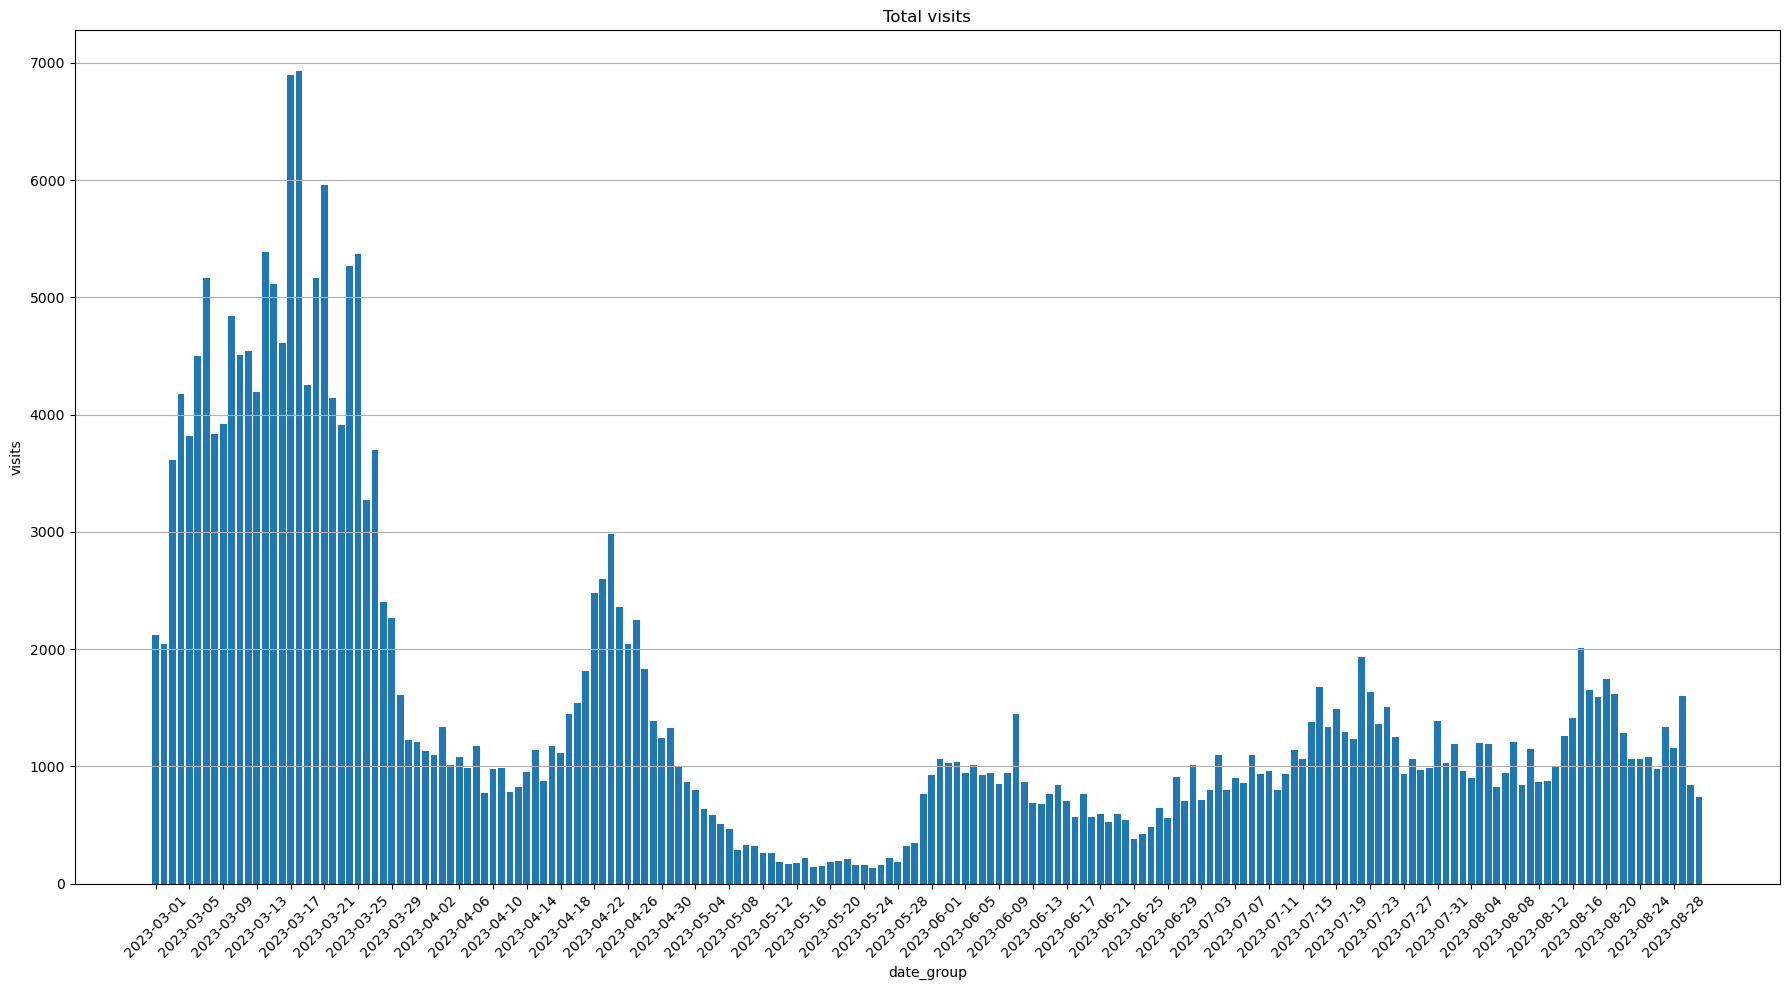

In [155]:
def total_visits_chart(clean_agr_visits):
    fig, ax = plt.subplots(figsize=(18,10))
    bars = plt.bar(x='date_group', height='visits', data=clean_agr_visits)
    #ax.bar_label(bars)
    plt.title('Total visits')
    plt.xlabel('date_group')
    plt.ylabel('visits')
    plt.xticks(clean_agr_visits['date_group'][::12], rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig('./Total_visits_chart.png')

total_visits_chart(clean_agr_visits)


## Итоговые визиты с разбивкой по платформам: web, android, ios

## Итоговые регистрации

## Итоговые регистрации с разбивкой по платформе: web, android, ios

## Конверсия по каждой платформе

## Средняя конверсия

## Стоимости реклам

## Визиты за весь период с цветовым выделением рекламной кампании

## Регистрации за весь период с цветовым выделением рекламной кампании